# Proyecto final, parte III
## Proceso de reversión a la media con tendencia funcional
_Paola Andrea Fernández López, Juliana Vallejo Díez, María Camila Vásquez Correa_

**Paquetes necesarios**

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

**Lectura de datos**

In [2]:
temp = pd.read_excel('temp.xlsx')
tick = temp['fecha4'][1097:2191]
temp = pd.read_csv('sinoutliers.csv', header=None)[0]
X = np.array(temp)

In [3]:
N = len(X)
dt = 1/252

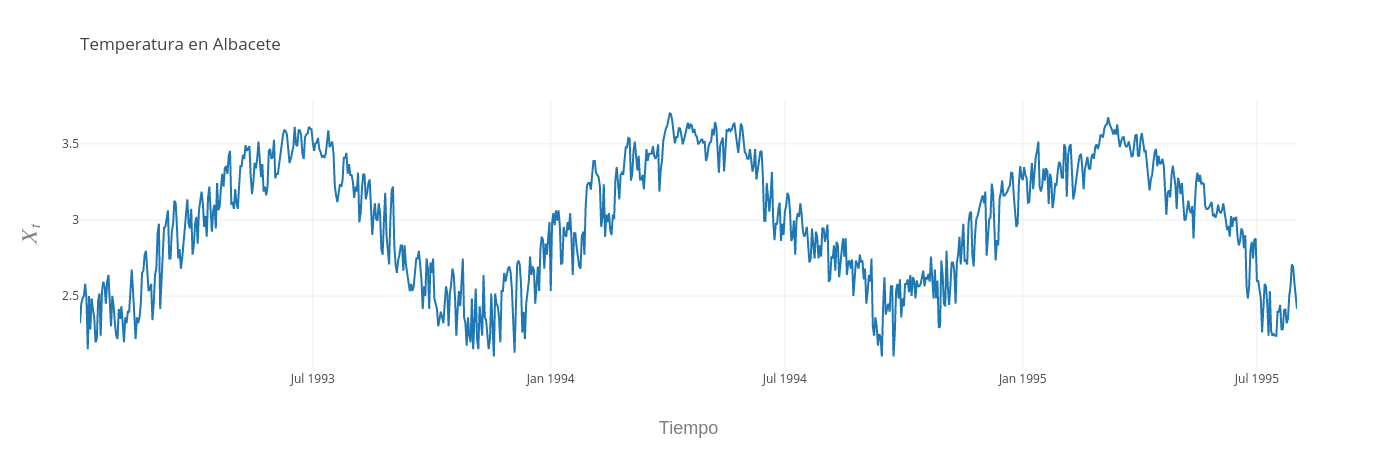

In [4]:
data = [go.Scatter(
            x = tick,
            y = X
)]
layout = go.Layout(
    title=go.layout.Title(
        text='Temperatura en Albacete',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Tiempo',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='$X_t$',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Albacete')

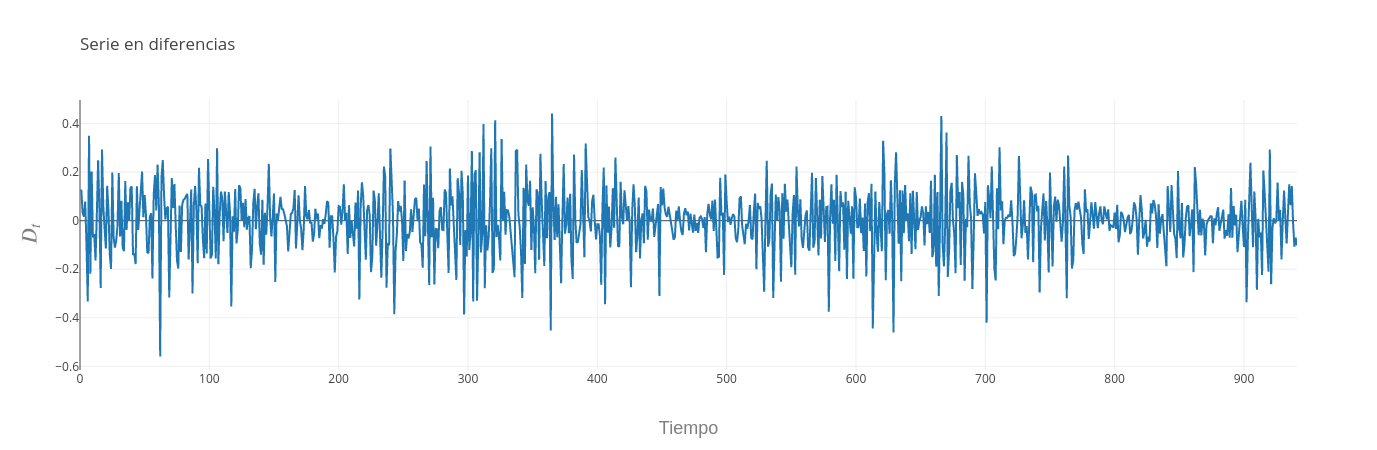

In [5]:
R = pd.Series(X).diff()
data = [go.Scatter(
            x = np.arange(0,N),
            y = R
)]
layout = go.Layout(
    title=go.layout.Title(
        text='Serie en diferencias',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Tiempo',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='$D_t$',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Diff')

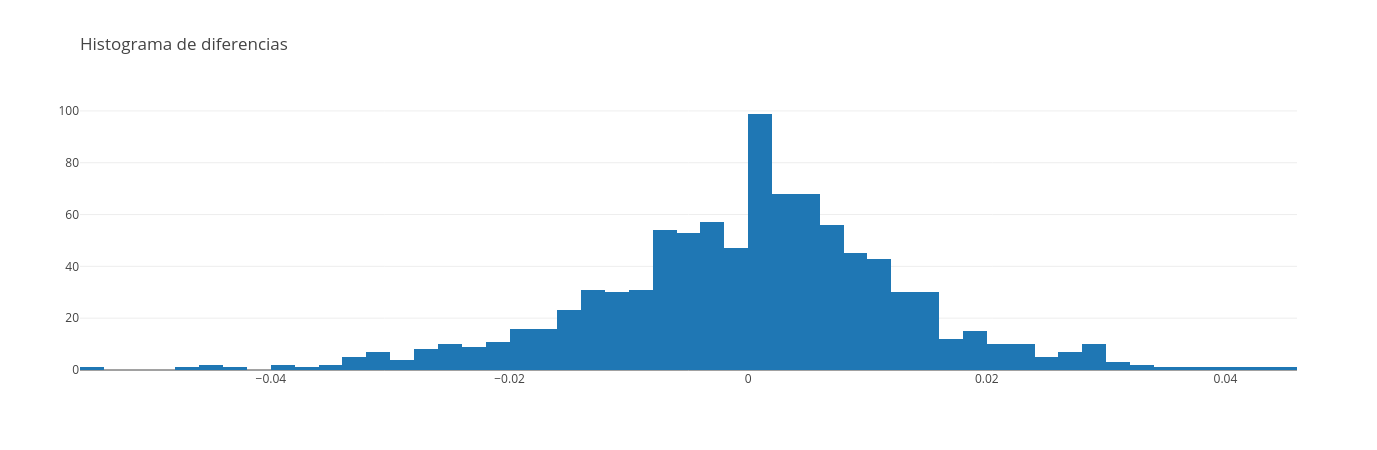

In [6]:
trace1 = go.Histogram(
    x = R/10
)

data = [trace1]
layout = go.Layout(
    title=go.layout.Title(
        text='Histograma de diferencias',
        xref='paper',
        x=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Retornos')

In [7]:
jb = stats.jarque_bera(R/10)
shapiro = stats.shapiro(R/10)
df = pd.DataFrame()
df['Jarque Bera'] = [jb[1]]
df['Shapiro Wilks'] = [shapiro[1]]
df

,Jarque Bera,Shapiro Wilks
0,NaN,1.0


In [8]:
def hFD(a, k_max): 
# Higuchi FD
    L = []
    x = []
    N = len(a)

    for k in range(1,k_max):
        Lk = 0
        for m in range(0,k):
            #we pregenerate all idxs
            idxs = np.arange(1,int(np.floor((N-m)/k)),dtype=np.int32)
            Lmk = np.sum(np.abs(a[m+idxs*k] - a[m+k*(idxs-1)]))
            Lmk = (Lmk*(N - 1)/(((N - m)/ k)* k)) / k
            Lk += Lmk

        L.append(np.log(Lk/(m+1)))
        x.append([np.log(1.0/ k), 1])

    (p, r1, r2, s)=np.linalg.lstsq(x, L)
    return p[0]

def hurst(signal):
    tau = []; lagvec = []

    #  Step through the different lags
    for lag in range(2,20):

    #  produce price difference with lag
        pp = np.subtract(signal[lag:],signal[:-lag])

    #  Write the different lags into a vector
        lagvec.append(lag)

    #  Calculate the variance of the difference vector
        tau.append(np.std(pp))

    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lagvec),np.log10(tau),1)

    # calculate hurst
    hurst = m[0]

    return hurst

df['Coeficiente de Hurst'] = hurst(X)
df['Dimensión Fractal'] = hFD(X, 8)

print(df.to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
 Jarque Bera &  Shapiro Wilks &  Coeficiente de Hurst &  Dimensión Fractal \\
\midrule
         NaN &            1.0 &              0.170786 &           1.777843 \\
\bottomrule
\end{tabular}



In [9]:
def numDer(mi):
    mid = [(2*mi[i+1] - 3*mi[i] + mi[i-1])/dt for i in range(1,len(mi)-1)]
    mid.insert(0, (mi[1] - mi[0])/dt)
    mid.append((mi[-1] - mi[-2])/dt)
    return mid

In [10]:
def alpha(mi, mid):
    al1 = [X[i] - X[i-1] - mid[i-1]*dt for i in range(1,N)]
    al1 = [al1[i-1]*(mi[i-1] - X[i-1]) for i in range(1,N)]
    al1 = [al1[i-1]/X[i-1]**(2*gamma) for i in range(1,N)]
    al1 = np.sum(al1)
    al2 = [mi[i-1] -X[i-1] for i in range(1,N)]
    al2 = [al2[i-1]/X[i-1]**gamma for i in range(1,N)]
    al2 = [(al2[i-1]**2)*dt for i in range(1,N)]
    al2 = np.sum(al2)
    return al1/al2

In [11]:
def sigma(mi, mid, alpha):
    s1 = [X[i] - X[i-1] for i in range(1,N)]
    s2 = [(alpha*(mi[i-1] - X[i-1]) + mid[i-1])*dt for i in range(1,N)]
    s = [s1[i] - s2[i] for i in range(N-1)]
    s = [(s[i-1]/X[i-1]**gamma)**2 for i in range(1,N)]
    s = np.sum(s)
    s = np.sqrt((1/(N*dt))*s)
    return s    

In [14]:
coseno = pd.read_csv('fun.csv', header=None)[0]

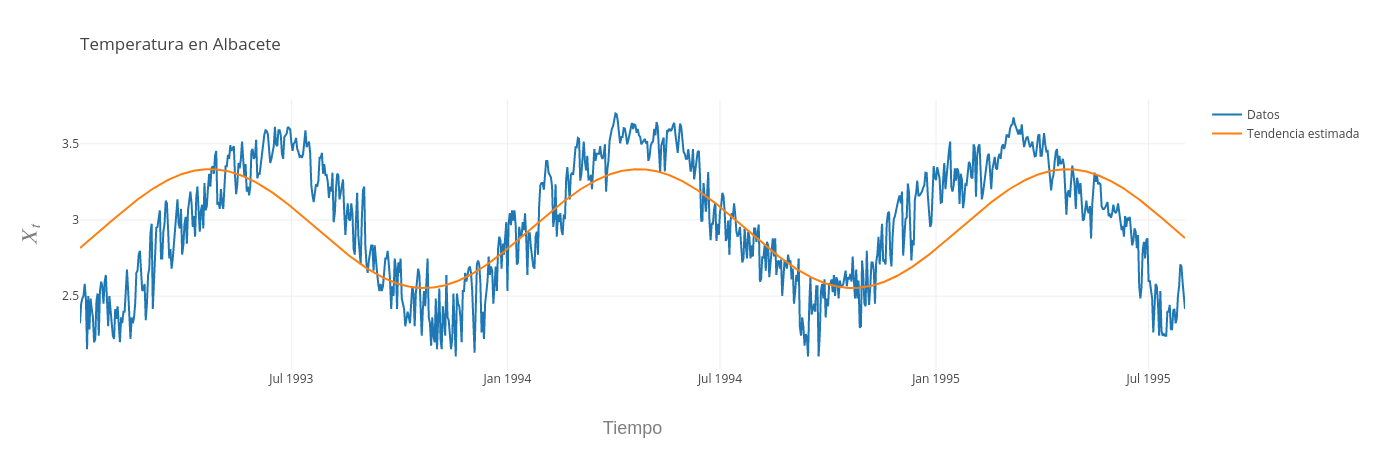

In [15]:
data = [go.Scatter(
            x = tick,
            y = X,
    name = 'Datos'
),
  go.Scatter(
            x = tick,
            y = coseno,
      name = 'Tendencia estimada'
    )]
layout = go.Layout(
    title=go.layout.Title(
        text='Temperatura en Albacete',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Tiempo',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='$X_t$',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Albacete')

In [16]:
gamma = 0

In [17]:
def alphae(muest):
    a1 = [(X[i] - X[i-1])*(muest[i-1] - X[i-1]) for i in range(1,N)]
    a1 = [a1[i-1]/(X[i-1]**(2*gamma)) for i in range(1,N)]
    a1 = np.sum(a1)
    a2 = [(((muest[i-1] - X[i-1])/X[i-1]**gamma)**2)*dt for i in range(1,N)]
    a2 = np.sum(a2)
    return a1/a2

In [18]:
def sigmae(muest, alphae11):
    s1 = [X[i] - X[i-1] for i in range(1,N)]
    s2 = [(alphae11*(muest[i-1] - X[i-1]))*dt for i in range(1,N)]
    s = [s1[i] - s2[i] for i in range(N-1)]
    s = [(s[i-1]/X[i-1]**gamma)**2 for i in range(1,N)]
    s = np.sum(s)
    s = np.sqrt((1/(N*dt))*s)
    return s 

In [19]:
muest = coseno
alphae2 = alphae(muest)
sigmae2 = sigmae(muest, alphae2)
print('alpha', alphae2)
print('sigma', sigmae2)

alpha 23.436962078963717
sigma 2.034239460213603


In [20]:
alphae2 = 1.1476
sigmae2 = 2.5033

In [21]:
k = 1000
X1 = np.zeros((k,N))
X0 = X[0]
X1[:, 0] = X0
errores = []
for i in range(k):
    error = []
    for j in range(1,N):
        X1[i,j] = X[j-1] + alphae2*(muest[j-1] - X[j-1])*dt + sigmae2*np.sqrt(dt)*np.random.normal()
        error.append(np.abs(X1[i,j] - X[j])/X[j])
    errores.append(np.mean(error))        

In [22]:
np.mean(errores)

0.056208263230832126

In [ ]:
data=[]
for i in range(k):
    trace1 = go.Scatter(
        y = X1[i],
        x = np.arange(N),
        showlegend=False
    )
    data.append(trace1)

trace2 = go.Scatter(
    y = X,
    x = np.arange(N),
    mode = 'lines',
    line = dict(color = 'rgb(0,0,0)'),
    name = 'Real'
)
data.append(trace2)
layout = go.Layout(
    title=go.layout.Title(
        text='Simulación con parámetros estimados',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Tiempo',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='$X_t$',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Estimacion')

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(X,lags=10)
plt.title('PACF para temperatura en Albacete')
plt.show()